In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import pylab as pl

from sklearn.cross_validation import cross_val_score 
from sklearn.cross_validation import KFold
import sklearn.preprocessing as pp
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso
from sklearn.decomposition import RandomizedPCA
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn import cross_validation
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve
import sklearn.decomposition
import sklearn.ensemble as sk
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV

import random
import sys
from scipy import stats
% matplotlib inline
%load_ext autoreload
%autoreload 2
from regression_functions import *
from reg_plots import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#Import Data

In [2]:
pod_number = 'D3'

In [3]:
df_all = pd.io.parsers.read_csv(filepath_or_buffer = 'data/D3_raw_features.csv', parse_dates = [0], index_col = 0)

##Declare whether to process raw or filtered data.

In [4]:
which_data = 1    #1 = filtered, 0 = raw
ref_column, leave_out_pod, pod_ozone = declare_filt_or_raw_dataset(which_data)

####Call the scaling function and create a dataframe with scaled data.

In [5]:
df_scaled, features = scale_features_and_create_day_column(df_all, ref_column)

####Add a 'day' column to the dataframe, and separate the data into training and holdout.

In [6]:
df_tr, df_hold, chunks_tr = sep_tr_and_holdout(df_scaled, ref_column)

####Create a custom cross-validation function that holds out each day.

In [7]:
lol = create_custom_cv(df_scaled)

#Linear Regression with Base Features

In [8]:
base_features = [pod_ozone,'Temp','Rh']

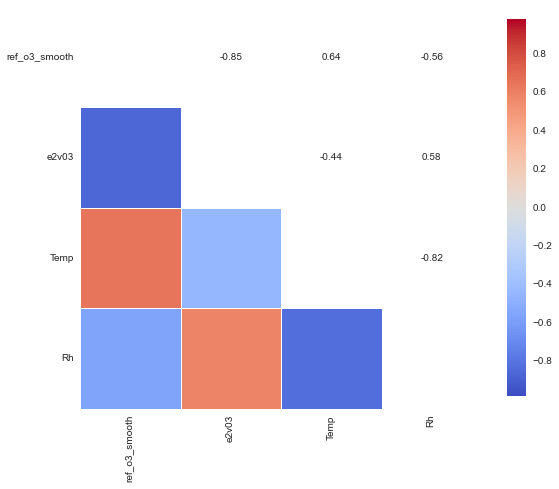

In [9]:
f, ax = plt.subplots(figsize=(9, 9))
sns.corrplot(df_tr[[ref_column] + base_features], annot=True, sig_stars=False,
             diag_names=False, ax=ax)

In [15]:
#Define the model.
lin_regr = linear_model.LinearRegression()
#find the MSE
MSE_CV, MSE_T, MSE_H, high_MSE_cv, X_pred_cv_base, y_cv, df_cv_lin_base, df_H_lin_base = cross_validation_by_day(lin_regr, base_features, df_tr, df_hold, chunks_tr, ref_column, lol)

Training RMSE: 5.8
Cross-Validation RMSE: 6.0 , High-Value CV RMSE: 13.0 , CV High Diff. in Mean.: -12.2%
Holdout RMSE: 5.0 , High-Value Holdout RMSE: 14.0 , Holdout High Diff. in Mean.: -17.2%


In [24]:
plot_hist(X_pred_cv_base, y_cv, 'predicted')
plot_hist(y_cv, X_pred_cv_base, 'reference')

NameError: name 'plot_hist' is not defined

####Plot the learning curve for a linear regression with the base features.

In [25]:
plt = plot_learning_curve(lin_regr, "Learning Curve (Linear Regression- Base Features)", df_tr[base_features].values, df_tr[ref_column].values, (0,150), lol, np.array([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1.0]), 'mean_squared_error')

NameError: name 'plot_learning_curve' is not defined

The MSE is high for the cross-validation set in this plot, and the training and cross-validation scores come together in this plot tells us that we have resonably high bias. Create more features and add polynomial effects to reduce bias. 

###Plot the residuals and comparison curves.

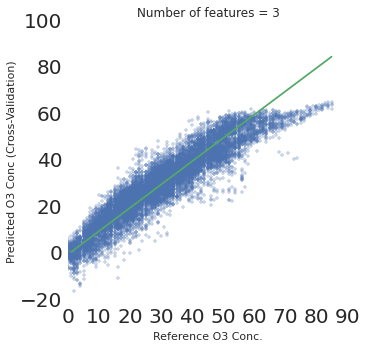

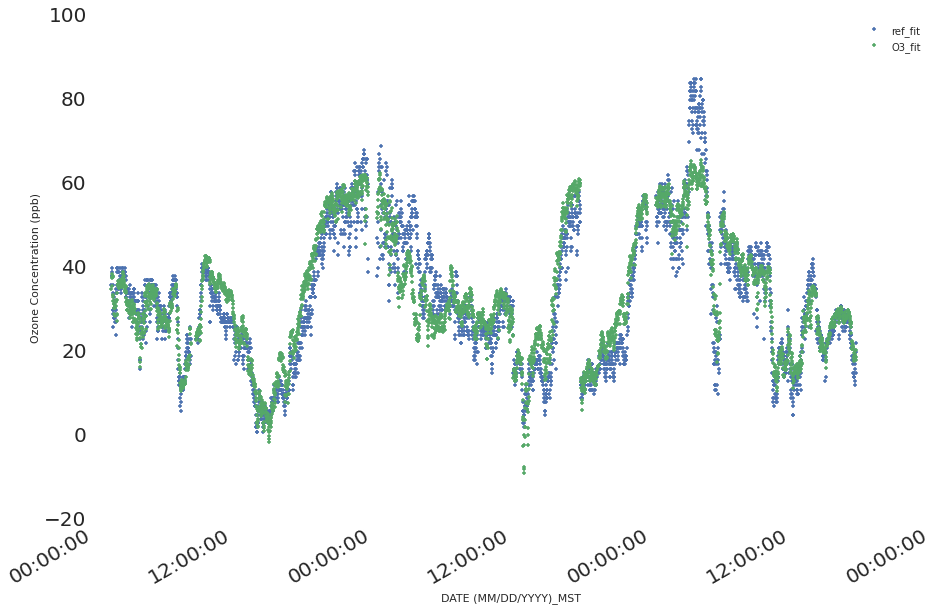

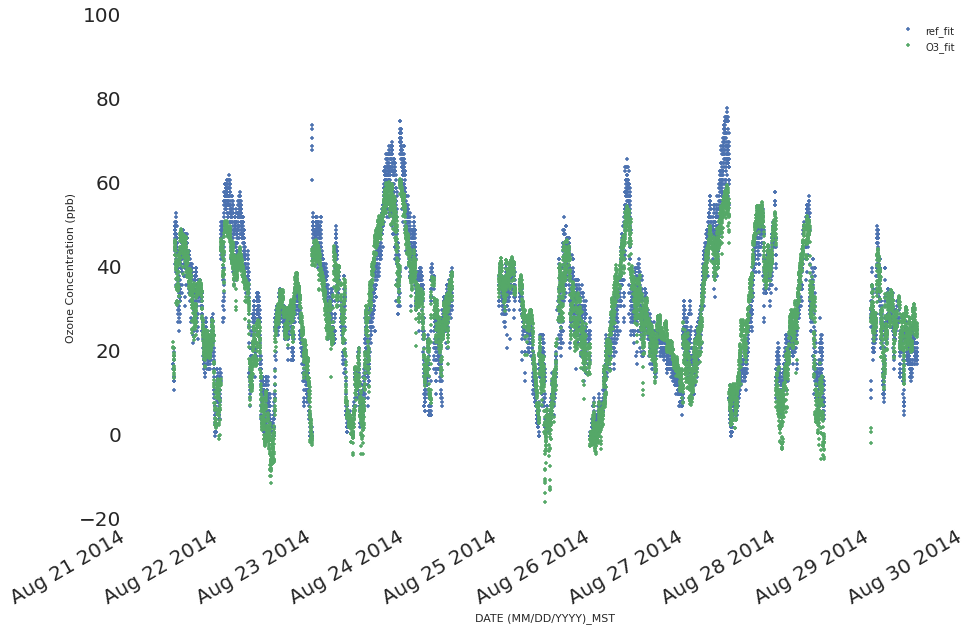

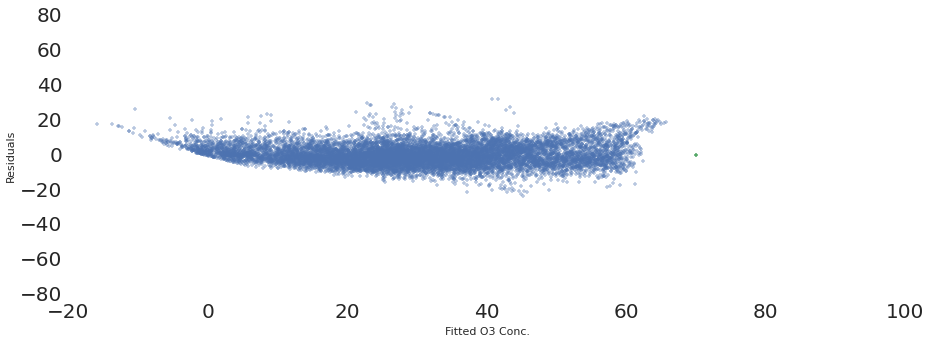

In [318]:
num_good_feat = len(base_features)
fitted_vs_ref_plot(df_cv_lin_base, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_base, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_base, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_cv_lin_base, ref_column)

###Linear Regression with All Features.

In [274]:
every_feature = list(df_tr.ix[:,0:len(df_scaled.columns)])
leave_out = ['ref_o3_smooth', 'chunk', 'day', 'O3_ppb', 'UnixTime']
all_features = [f for f in every_feature if f not in leave_out]
MSE_CV, MSE_T, MSE_H, high_MSE_cv, X_pred_cv_all, y_cv, df_cv_lin_all, df_H_lin_all = cross_validation_by_day(lin_regr, all_features, df_tr, df_hold, chunks_tr, ref_column, lol)

Training RMSE: 3.3
Cross-Validation RMSE: 9.0 , High-Value CV RMSE: 9.0 , CV High Diff. in Mean.: -3.8%
Holdout RMSE: 6.0 , High-Value Holdout RMSE: 9.0 , Holdout High Diff. in Mean.: 11.1%


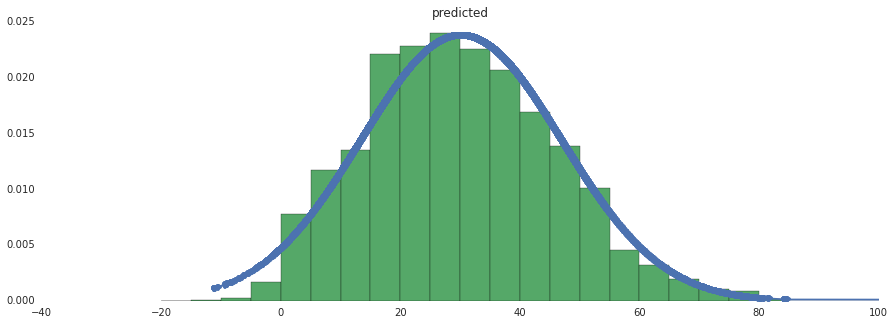

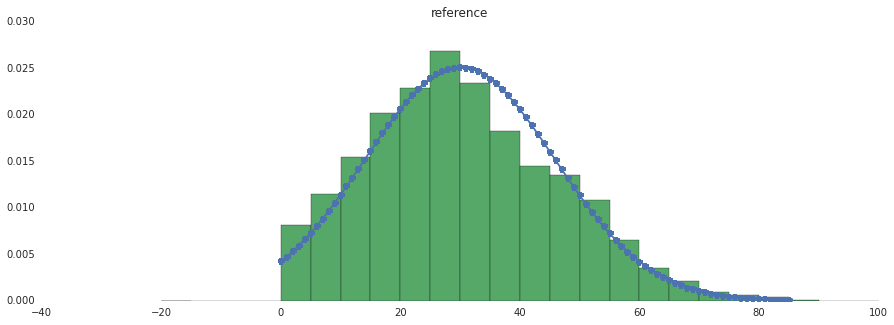

In [278]:
plot_hist(X_pred_cv_all, y_cv, 'predicted')
plot_hist(y_cv, X_pred_cv_all, 'reference')

####Plot a learning curve with all features.

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

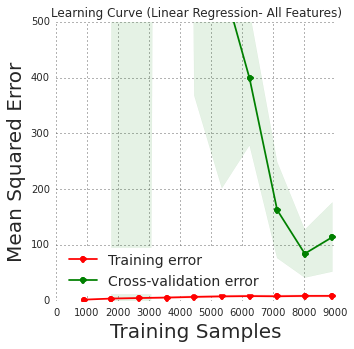

In [279]:
plot_learning_curve(lin_regr, "Learning Curve (Linear Regression- All Features)", df_tr[all_features].values, df_tr[ref_column].values, (0,500), lol, np.array([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]), 'mean_squared_error')

The uncertainty in the cross-validation score is enormous, and it's very far away, from the training score, which indicates that we now have high variance, and need to reduce the number of features.

###Plot the residuals and comparison curves.

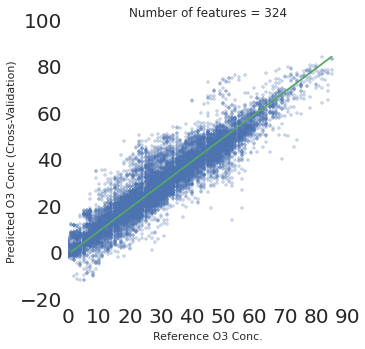

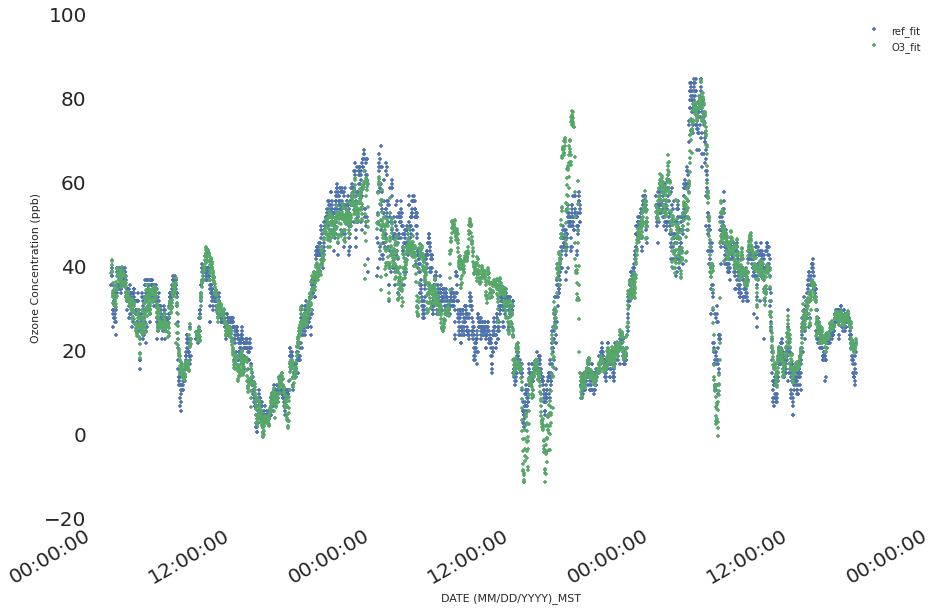

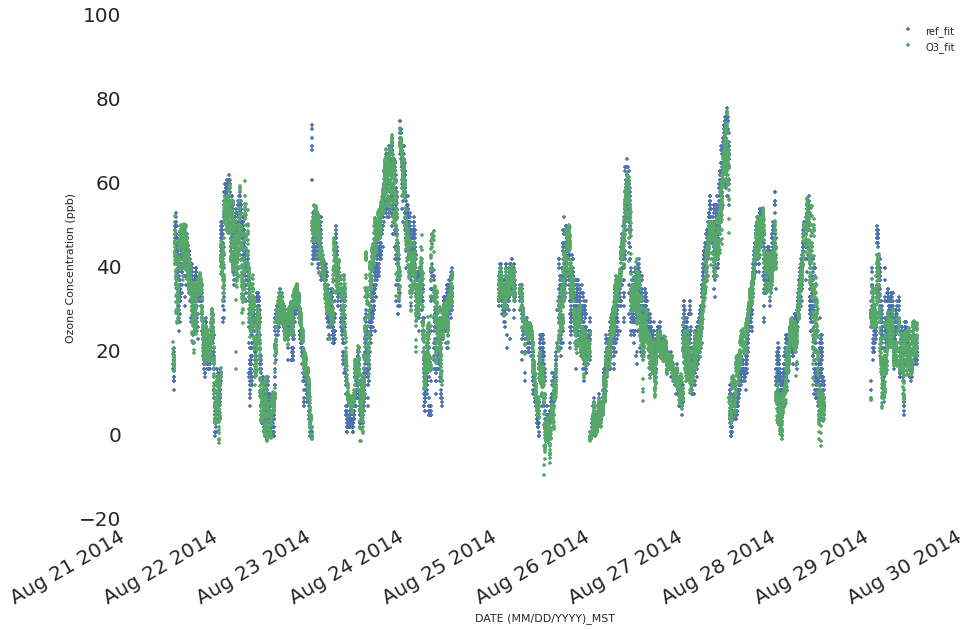

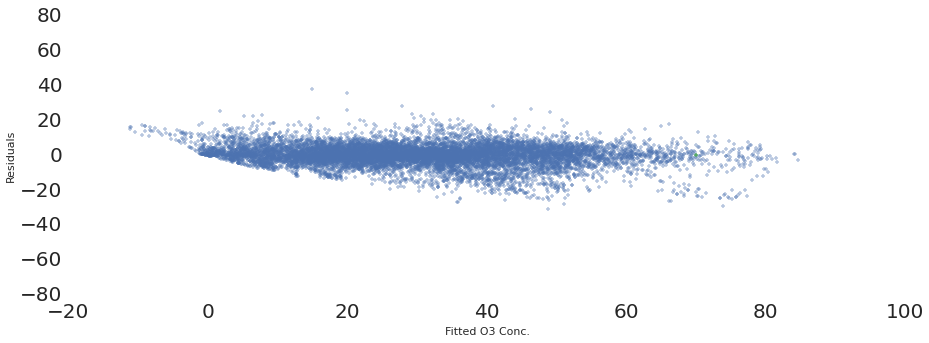

In [311]:
num_good_feat = len(all_features)
fitted_vs_ref_plot(df_cv_lin_all, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_all, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_all, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_cv_lin_all, ref_column)

#Forward Selection

####Declare rather you want to use MSE or a custom error function:

In [282]:
error_func = 'custom_mse' #'custom_mse', 'custom_mae' or 'mean_squared_error'

In [283]:
#make a list of features from the column titles in the dataframe
features = list(df_all.columns)
leave_out = ['Zenith Angle [degrees]','UnixTime', 'pod_o3_smooth', 'O3_ppb', 'ref_o3_smooth', ref_column, 'day', 'chunk']
features = [f for f in features if f not in leave_out]
fs_features, score, MSE = forward_selection_lodo(lin_regr, features, df_tr[[ref_column] + features].dropna(), error_func, ref_column, lol)

Next best Feature:  e2v03_int_lead_5 , Score:  245.3
Next best Feature:  temp_cu , Score:  98.0
Next best Feature:  o3_temp_rh_int_lead_5 , Score:  55.0
Next best Feature:  ln_O3_int_lag_60 , Score:  46.0
Next best Feature:  days from start , Score:  38.3
Next best Feature:  temp_sq_mult_rh_sq , Score:  36.3
Next best Feature:  ln_o3_temp_rh_int_lag_30 , Score:  31.0
Next best Feature:  ln_o3_temp_slope_lead_90 , Score:  29.7
Next best Feature:  ln_o3_rh_slope_lead_90 , Score:  29.0
Next best Feature:  o3_temp_rh_slope_lead_60 , Score:  28.3
Next best Feature:  temp_rh_slope_lead_90 , Score:  27.7
Next best Feature:  Rh_slope_lag_30 , Score:  27.3
Next best Feature:  ln_O3_int_lead_15 , Score:  26.3
Next best Feature:  ln_temp_slope_lag_30 , Score:  26.0
Next best Feature:  Rh_slope_lag_15 , Score:  25.7
Next best Feature:  o3_temp_slope_lead_90 , Score:  25.3
Next best Feature:  e2v03_slope_lag_30 , Score:  25.3
Next best Feature:  e2v03_slope_lead_15 , Score:  25.3
Next best Feature:

TypeError: __init__() got an unexpected keyword argument 'size'

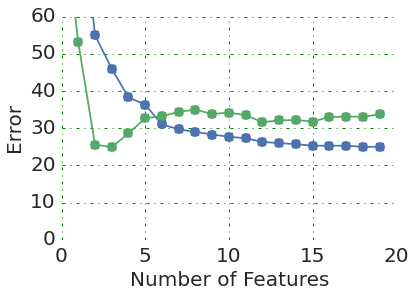

In [302]:
plot_error_vs_features(score, MSE)

#Check Residuals

###Plot cross-validation fitted data versus reference data, and choose number of features.

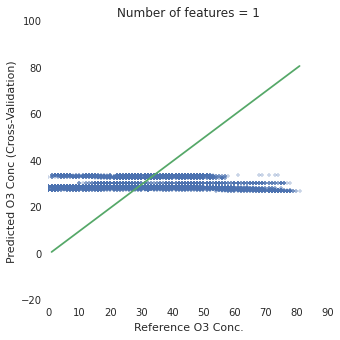

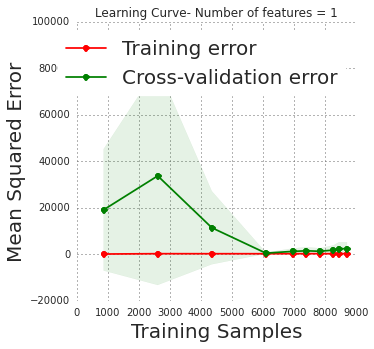

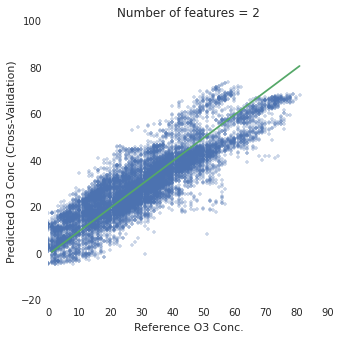

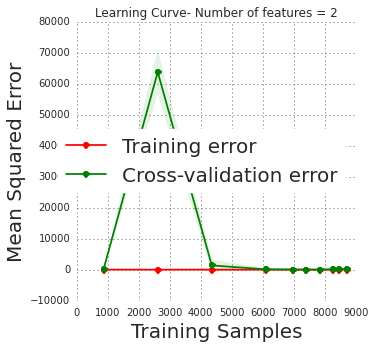

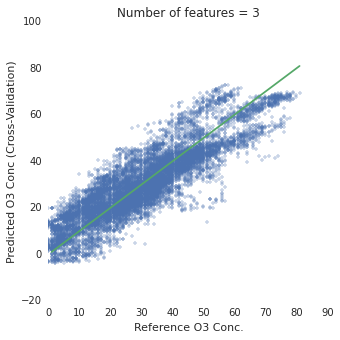

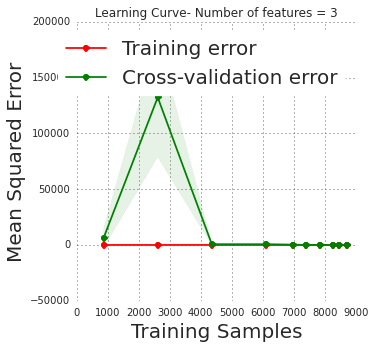

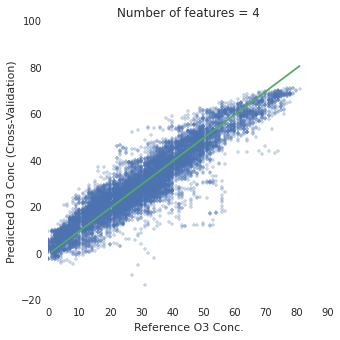

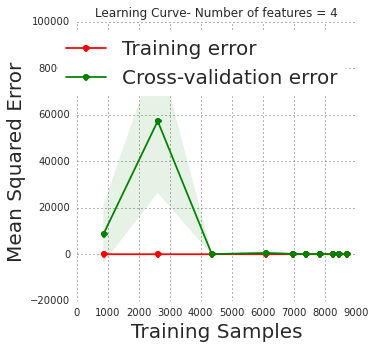

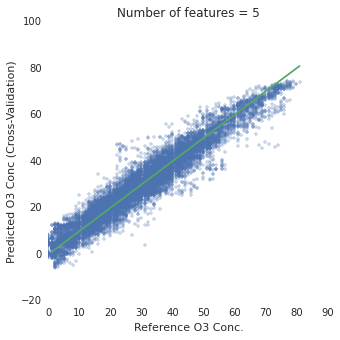

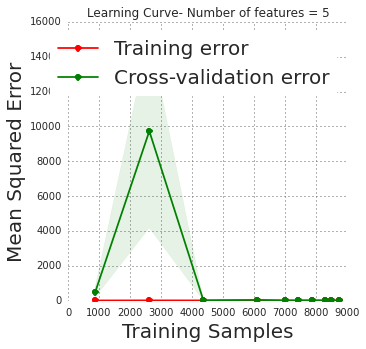

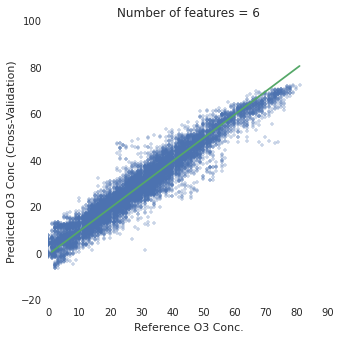

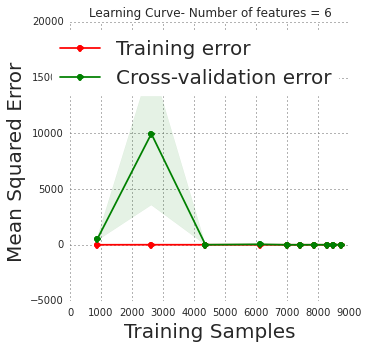

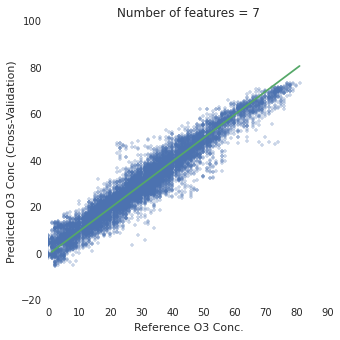

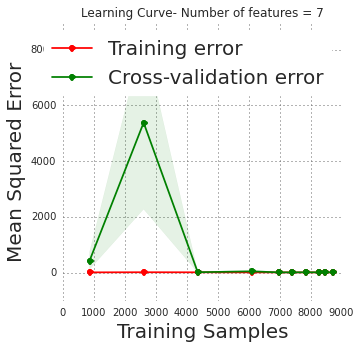

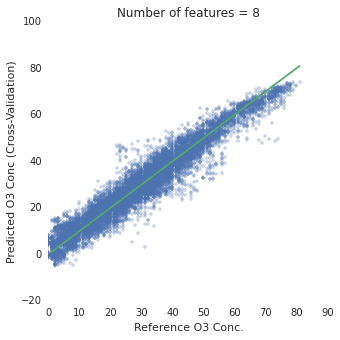

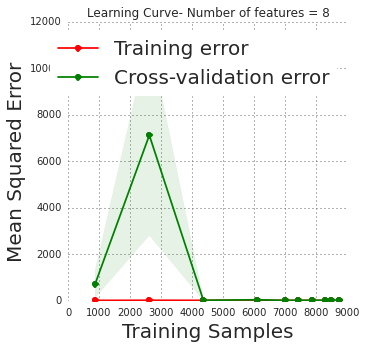

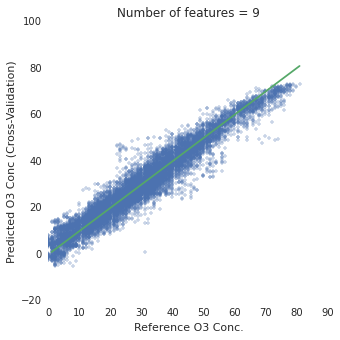

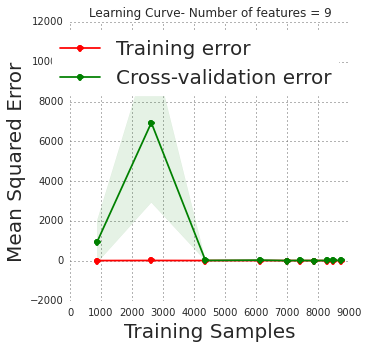

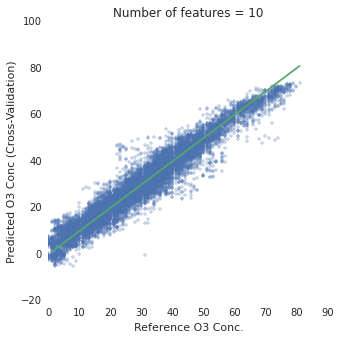

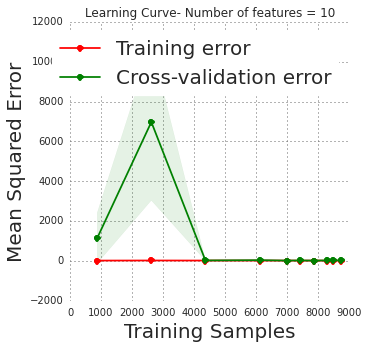

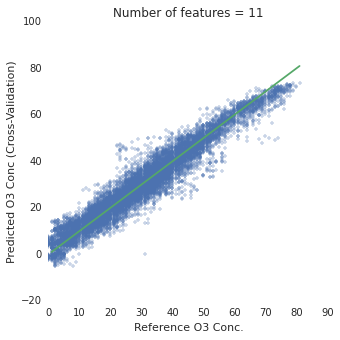

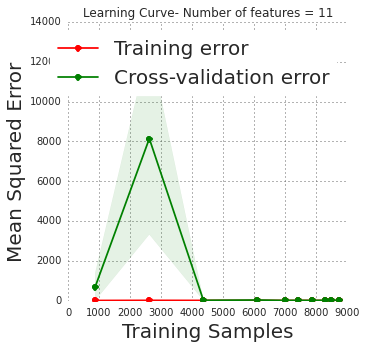

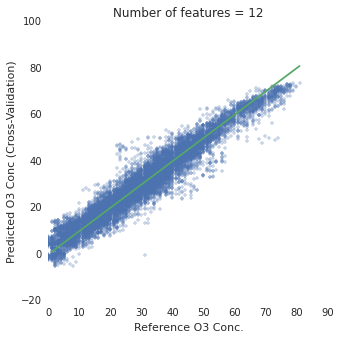

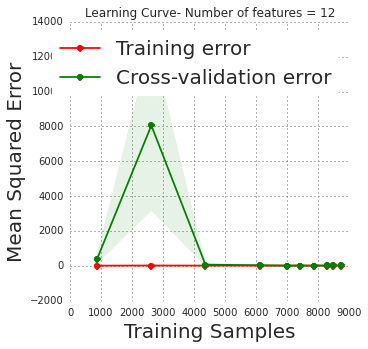

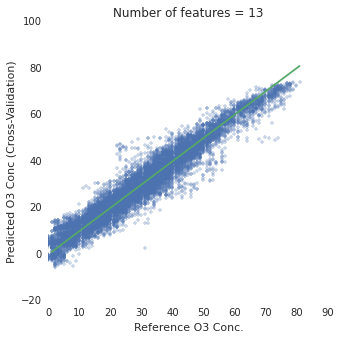

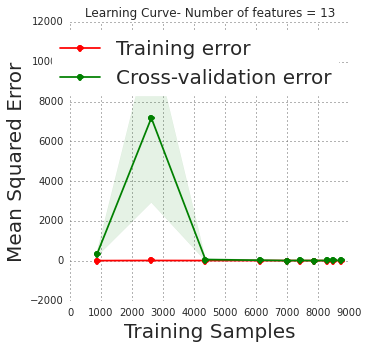

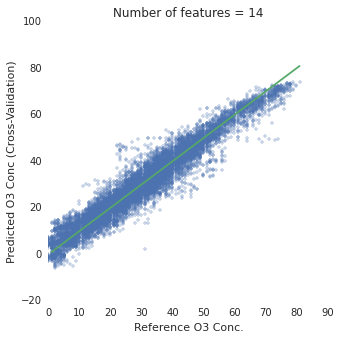

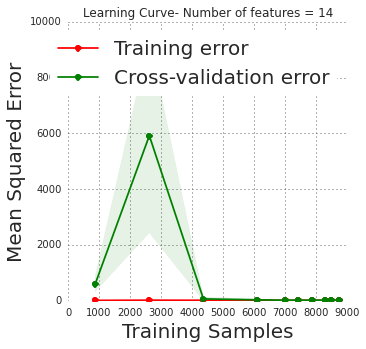

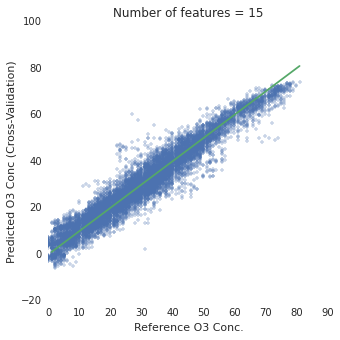

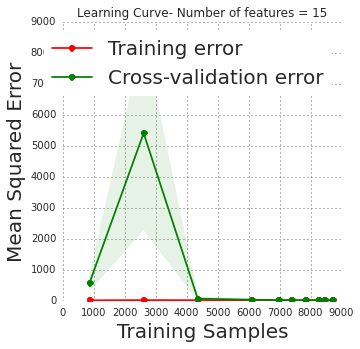

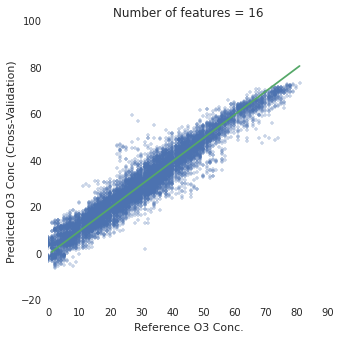

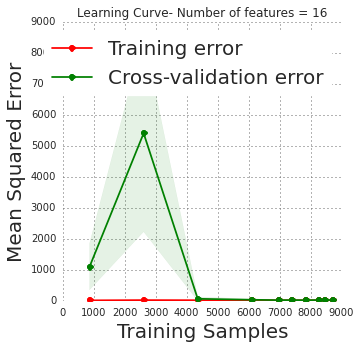

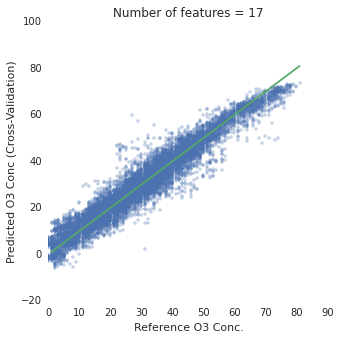

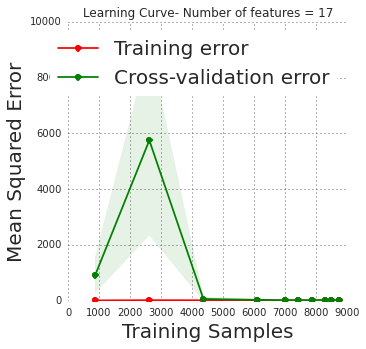

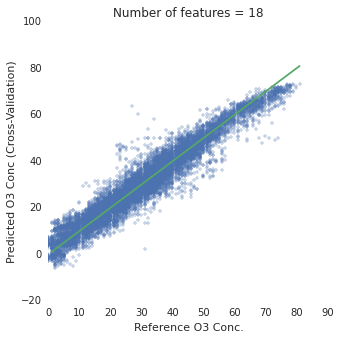

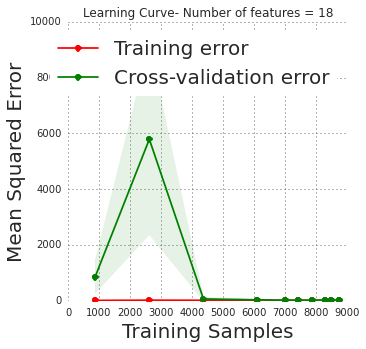

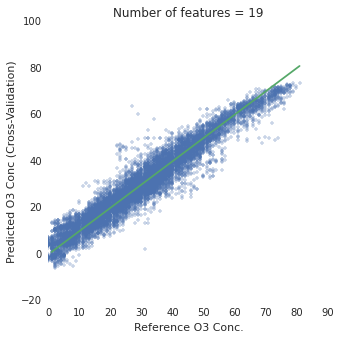

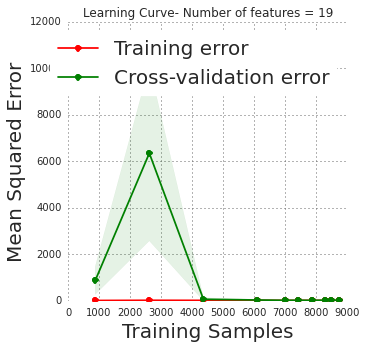

In [251]:
for i in range(1,20):
    num_good_feat = i
    df_cv_1, df_H_1 = find_fitted_cv_values_for_best_features(df_tr, df_hold, fs_features, num_good_feat, linear_model.LinearRegression(), chunks_tr, ref_column)
    fitted_vs_ref_plot(df_cv_1, i, ref_column) 
    plot_learning_curve(lin_regr, "Learning Curve- Number of features = " + str(i), df_tr[fs_features[:i]].values, df_tr[ref_column].values, (0,40), lol, np.array([0.1, 0.3, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95,0.97, 1.0]), 'mean_squared_error')

###Enter the chosen number of features, and plot the cv data and residuals below.

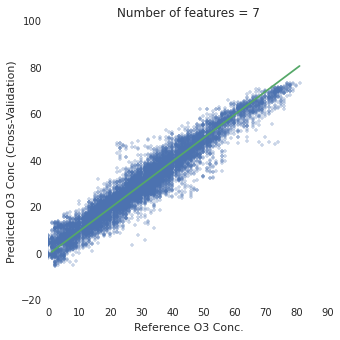

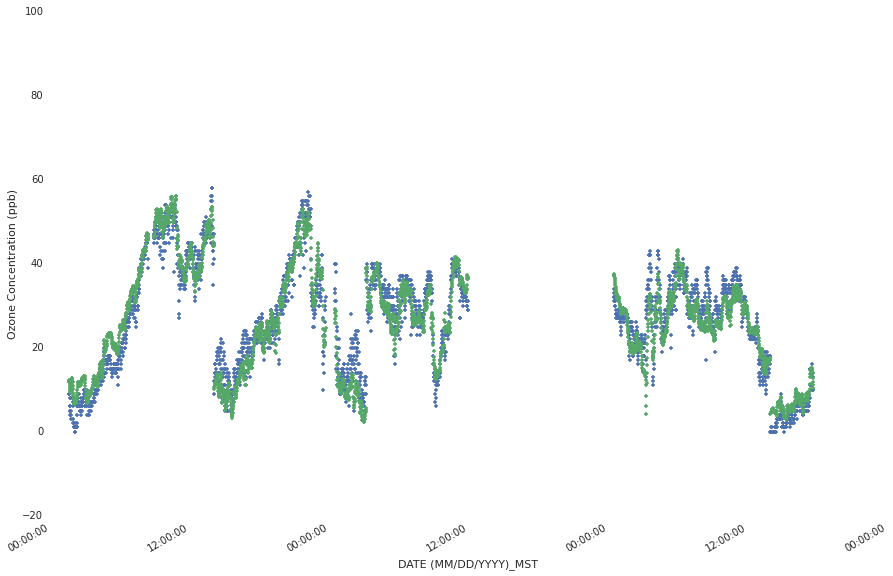

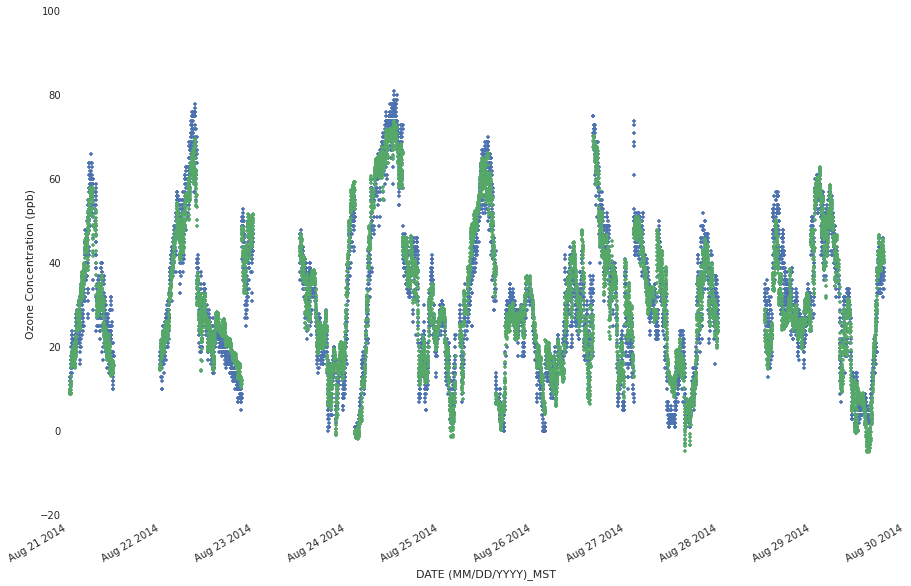

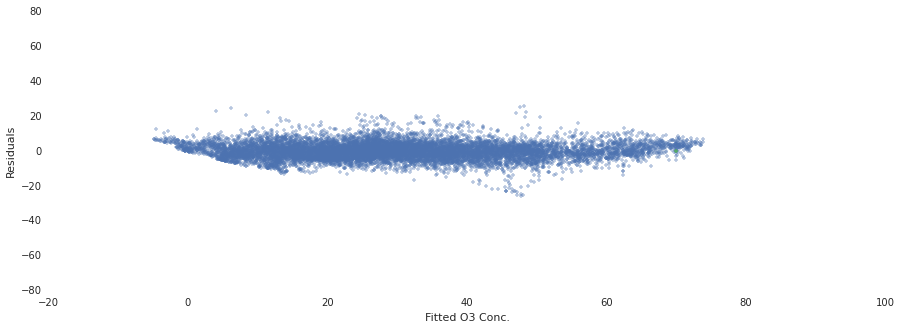

In [252]:
num_good_feat = 7
df_lin_regr_best_feat_cv, df_lin_regr_best_feat_H  = find_fitted_cv_values_for_best_features(df_tr, df_hold, fs_features, num_good_feat, linear_model.LinearRegression(), chunks_tr, ref_column)
fitted_vs_ref_plot(df_lin_regr_best_feat_cv, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat_cv, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat_cv, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_lin_regr_best_feat_cv, ref_column)

##Linear Regression with Best Features

In [253]:
best_features = fs_features[:num_good_feat]
#best_features = ['days from start', 'ln_O3_int_lead_5', 'temp_cu', 'ln_03_mult_ln_rh', 'Rh_int_lag_110', 'e2v03_int_lead_5']
MSE_CV, MSE_T, MSE_H, high_MSE_cv, X_pred_cv_best, y_cv_best, df_cv_lin_best, df_H_lin_best = cross_validation_by_day(lin_regr, best_features, df_tr, df_hold, chunks_tr, ref_column, lol)

Training RMSE: 4.3
Cross-Validation RMSE: 4.0 , High-Value CV RMSE: 9.0 , CV High Diff. in Mean.: -4.6%
Holdout RMSE: 4.0 , High-Value Holdout RMSE: 6.0 , Holdout High Diff. in Mean.: -6.2%


In [254]:
print best_features

['days from start', 'ln_O3_int_lead_5', 'ln_rh_int_lag_75', 'temp_sq', 'ln_o3_rh_int_lead_5', 'rh_sqrt', 'ln_temp_slope_lag_45']


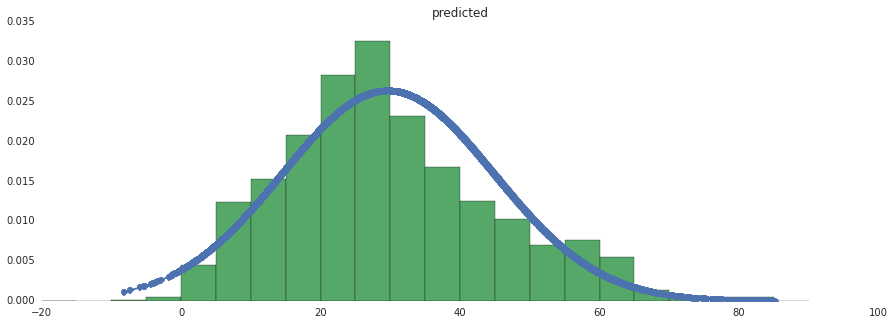

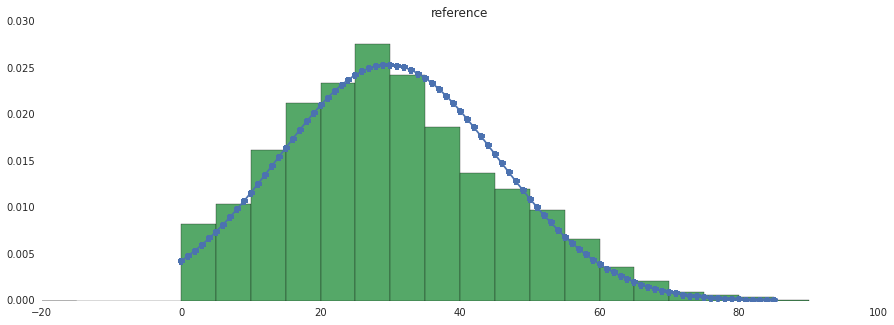

In [142]:
plot_hist(X_pred_cv_best, y_cv_best, 'predicted')
plot_hist(y_cv_all, X_pred_cv_best, 'reference')

#Ridge Regression

In [63]:
fs_features = all_features
num_good_feat_ridge = len(all_features)

In [64]:
#define the training data
df_fits = df_tr[fs_features[:num_good_feat_ridge] + [ref_column] + ['day']].dropna()
X = df_scaled[fs_features[:num_good_feat_ridge]].values
y = df_scaled[ref_column].values

###Find the best lambda value using cross-validation

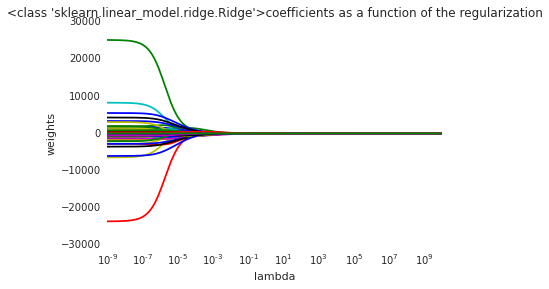

Best Lambda: 665.306225001  ,  CV RMSE: 8.2  ,  High-Value RMSE: 9.1


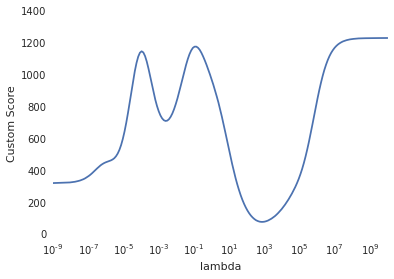

In [65]:
best_lambda_ridge, custom_sc_ridge, MSE_ridge = find_best_lambda(Ridge, fs_features[:num_good_feat_ridge], df_fits, ref_column, 'custom_mse', lol, X, y)

####Use the best lambda value found above to find holdout values.

In [66]:
df_ridge_fit = find_residuals_and_fitted_cv_values(Ridge, df_tr, fs_features[:num_good_feat_ridge], chunks_tr, ref_column, best_lambda_ridge)

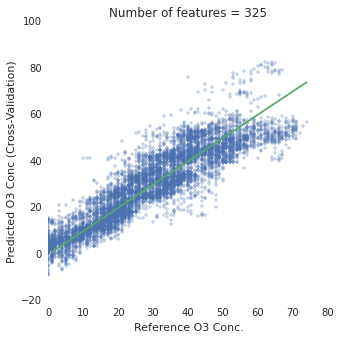

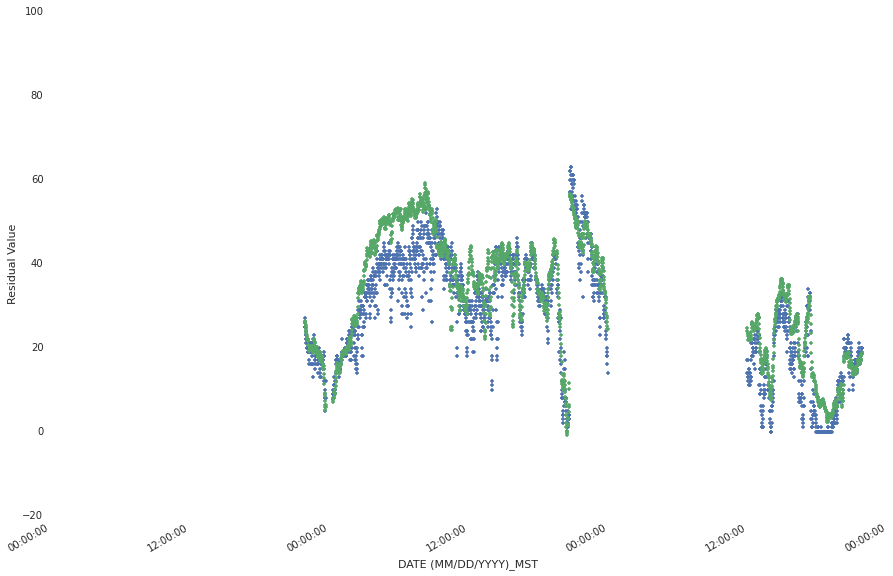

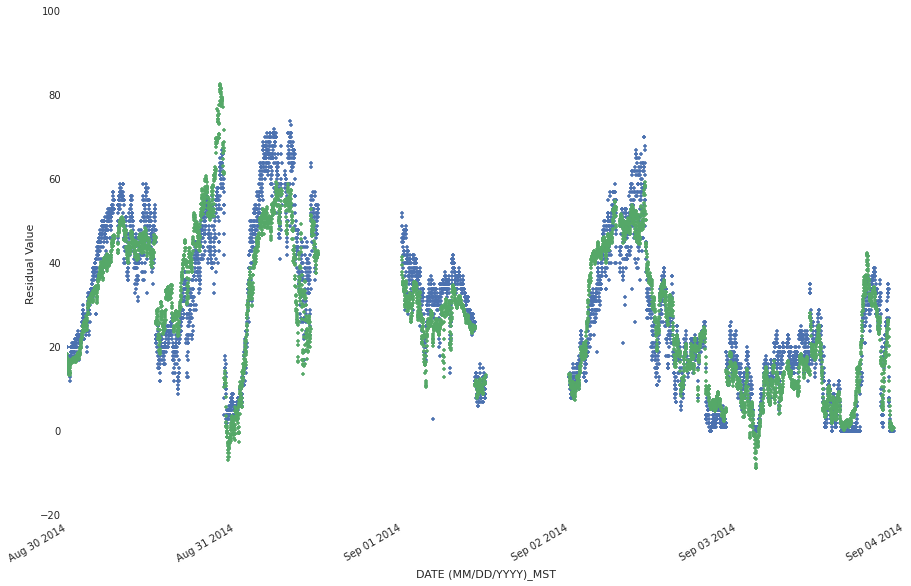

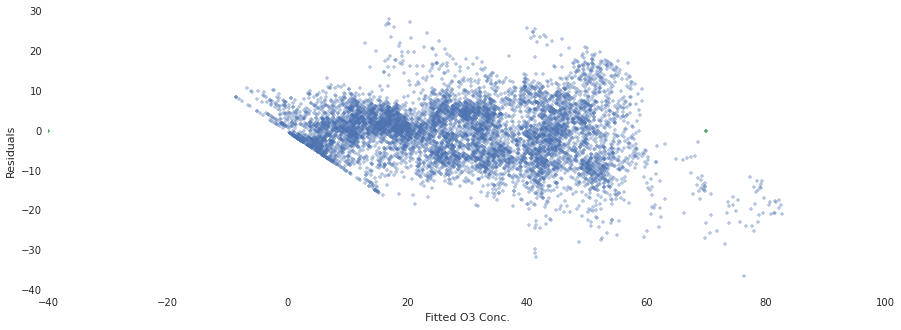

In [67]:
fitted_vs_ref_plot(df_ridge_fit, num_good_feat_ridge, ref_column)
plot_fitted_and_ref_vs_time(df_ridge_fit, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_ridge_fit, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_ridge_fit, ref_column)

#Lasso

In [177]:
best_lambda_lasso, custom_sc_lasso, MSE_lasso = find_best_lambda(Lasso, fs_features[:num_good_feat_ridge], df_fits, ref_column, 'custom_mse', lol, X, y)

KeyboardInterrupt: 

####Use the best lambda value found above to find holdout values.

In [ ]:
df_fit_lasso = find_residuals_and_fitted_cv_values(Lasso, df_fits, fs_features[:num_good_feat], chunks_tr, ref_column, best_lambda_lasso)

In [ ]:
fitted_vs_ref_plot(df_fit_lasso, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_fit_lasso, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_fit_lasso, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_fit_lasso, ref_column)
plot_resid_vs_time(resid, pod_number, 1)
plot_resid_vs_time(resid, pod_number, 2)

#Random Forest 

In [ ]:
fs_features = ['ln_O3_int_lead_5', 'Temp_int_lag_110', '03_mult_rh_sq', 'ln_rh_slope_lead_110', 'Rh_slope_lead_110', 'ln_temp_slope_lag_35', '03_mult_temp_cu', 'temp_rh_slope_lag_110', 'temp_rh_slope_lag_35', 'ln_temp_slope_lead_65', 'Temp_int_lead_20', 'Temp_slope_lag_65', 'diff', 'Temp_int_lead_5', 'o3_temp_rh_slope_lag_65', 'e2v03_int_lag_95', 'o3_temp_int_lag_95', 'ln_O3_int_lag_95', 'Temp_slope_lag_20', 'Temp_slope_lag_80', 'temp_rh_slope_lead_35', 'e2v03_slope_lead_95', 'o3_rh_int_lead_95', 'e2v03_slope_lead_80', 'ln_O3_slope_lag_20', 'ln_temp_slope_lead_80']
num_good_feat = len(fs_features)

In [ ]:
#choose to run default parameters or look for the best parameters (0 = default, 1 = other)
options = 1

In [ ]:
if options == 0:
    MSE_CV, df_fit_rf = find_MSE_random_forest(df_fits, fs_features[:num_good_feat], chunks_tr, options, ref_column)
else:
    MSE_CV = find_MSE_random_forest(df_fits, fs_features[:num_good_feat], chunks_tr, options, ref_column)

In [ ]:
if options == 1:
    #i,j = np.where(MSE_CV == MSE_CV.min())
    #plot_param_select_MSE(MSE_CV, i, j)
    print 'Daily MSE = ', MSE_CV
    print 'mean MSE = ', MSE_CV.mean(axis=2, dtype = int)
else: 
    print 'mean MSE = ', int(np.mean(MSE_CV))
    print 'Daily MSE = ' + str(MSE_CV)

In [ ]:
if options == 1:
    df_fit_rf = find_fitted_cv_values_for_best_features(df_tr, fs_features, num_good_feat, sk.RandomForestRegressor(n_estimators=300, oob_score = True, n_jobs = -1), chunks_tr, ref_column)

In [ ]:
fitted_vs_ref_plot(df_fit_rf, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_fit_rf, ref_column)
plot_resid_vs_time(resid, pod_number, 1)
plot_resid_vs_time(resid, pod_number, 2)

#Vector Support Machine

In [ ]:
fs_features = ['ln_03_mult_ln_rh', 'UnixTime', 'ln_rh_slope_lag_110', 'temp_cu', 'ln_03_mult_ln_temp', 'o3_rh_int_lag_95', 'ln_rh_slope_lead_110', 'ln_O3_int_lag_110', 'o3_temp_int_lag_35', 'ln_o3_rh_slope_lead_110', 'ln_temp_slope_lag_95', 'Temp_slope_lag_80', 'ln_o3_rh_int_lead_35', 'ln_o3_temp_int_lead_95', 'ln_temp_rh_slope_lead_65', 'Temp_slope_lag_95', 'ln_rh_slope_lag_5', '03_sq_mult_rh_sq_&_temp_sq', 'e2v03_int_slide_2_to_12_lead', 'ln_O3_int_slide_2_to_12_lead', 'Temp_int_slide_2_to_12_lead', 'ln_temp_int_slide_2_to_12_lead', 'Rh_int_slide_2_to_12_lead', 'ln_rh_int_slide_2_to_12_lead', 'diff', 'Temp_slope_lead_20', 'ln_rh_slope_lead_5', 'ln_rh_slope_lead_20', 'ln_o3_temp_slope_lag_65', 'o3_temp_slope_lag_95', 'ln_o3_rh_slope_lag_95', 'o3_rh_slope_lag_95', 'ln_o3_temp_slope_lag_110', 'ln_o3_temp_slope_lag_35', 'Temp_slope_lead_5', 'Temp_slope_lag_20']
num_good_feat = 25

In [ ]:
def fit_vsm_and_find_MSE(features, df, days, lol, ref_column):
        
    MSE_CV = []
    day_date = []
    df_svm_fit = df_tr.copy()

    for d in chunks_tr:

        X_T, y_T, X_CV, y_CV = make_numpy_arrays_for_tr_and_holdout(features, df[df.day != d], df[df.day == d], ref_column)   

        parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
        svr = SVR()
        vsm = GridSearchCV(svr, parameters)
        vsm.fit(X_T, y_T)  

        if d == days[0]:
            fitted_CV_o3 = vsm.predict(X_CV)
        else:
            fitted_CV_o3 = np.concatenate((fitted_CV_o3, vsm.predict(X_CV)))
        
        day_date.append(d)  
        MSE_CV.append(int(np.mean(y_CV - vsm.predict(X_CV)**2)))
        
        print d, 'Cross-Val MSE: ', MSE_CV
        print vsm.get_params
        
    print 'Cross-Validation MSE: ', np.mean(MSE_CV)
    return MSE_CV, fitted_CV_o3 

In [ ]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = SVR()
vsm = GridSearchCV(svr, parameters)
vsm.fit(X, y, cv = lol) 

In [ ]:
MSE_CV_day, fitted_CV_o3_vsm = fit_vsm_and_find_MSE(fs_features, df_tr, chunks_tr, lol, ref_column)  

In [ ]:
vsm.get_params

In [ ]:
fitted_vs_ref_plot(df_fit_lasso, num_good_feat)
plot_fitted_and_ref_vs_time(df_fit_lasso, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_fit_lasso, pod_number, 2, ref_column)
resid = plot_resid_vs_conc(df_fit_lasso, ref_column)
plot_resid_vs_time(resid, pod_number, 1)
plot_resid_vs_time(resid, pod_number, 2)

In [ ]:
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV

def fit_vsm_and_find_MSE(features, df_T, df_H, d, days, fitted_holdout_o3, lol):
    
    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
    svr = SVR()
    vsm = GridSearchCV(svr, parameters, scoring = make_scorer(custom_mse_scoring_function, greater_is_better = False), cv = lol)
    vsm.fit(X_T, y_T)  
    
    
    if d == days[0]:
        fitted_holdout_o3 = vsm.predict(X_H)
    else:
        fitted_holdout_o3 = np.concatenate((fitted_holdout_o3, vsm.predict(X_H)))
        
    MSE_CV = int(np.mean((y_H - vsm.predict(X_H))**2))
    
    print d,'Cross-Val MSE: ', MSE_CV
    print vsm.get_params
    return MSE_CV, fitted_holdout_o3

In [ ]:
def avg_cv_score_for_all_days(df, features, ref_column, model, scoring_metric):
    X = df[features].values
    y = df[ref_column].values
    if scoring_metric == 'custom_mse':
        score_cv = -np.mean(cross_val_score(model, X, y, cv = lol, scoring = make_scorer(custom_mse_scoring_function, greater_is_better = False)))        
    elif scoring_metric == 'custom_mae':
        score_cv = -np.mean(cross_val_score(model, X, y, cv = lol, scoring = make_scorer(custom_mae_scoring_function, greater_is_better = False)))        
    else:
        score_cv = -np.mean(cross_val_score(model, X, y, cv = lol, scoring = scoring_metric))
    return score_cv